# Part 6

In [1]:
## Setup
import optilibrary as ot
import numpy as np
np.random.seed(1)

from scipy.linalg import norm

In [2]:
X_train, y_train, X_test, y_test, cols = ot.importData(p=0.2)
n, d = X_train.shape

## Question 1: 
_Apply randomized block coordinate descent to your problem by considering a full batch of your dataset, and compare it with gradient descent. Is the use of coordinate descent beneficial on your problem?_

The coordinate descent method implemented here selects, at iteration $k$, a single coordinate $j_k \in \{1,\dots,d\}$ and for a predetermined stepsize $\alpha_k>0$, performs the following gradient update
$$ 
    \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \nabla_{j_k} f(\mathbf{x}_k) \mathbf{e}_{j_k},
$$
where $\nabla_{j_k}$ is shorthand for $\nabla_{j_k} f(\mathbf{x}) := [\nabla f(\mathbf{x})]_{j_k}$,  $x\in\mathbb{R}^d$ and $\mathbf{e}_{j_k}$ canonical basis vector for coordinate $j_k$ in $\mathbb{R}^d$.

We implement RCD with regularisation parameters $$\lambda \in \{0.001, 0.01, 0.1, 1\}$$
and run each iteration 300 times for a fixed step size $\alpha=0.015$ which is optimal (as determined in Part 1).

In [3]:
#Different block values
from optilibrary import rcd_lasso

lbda = [0.001,0.01,0.1, 1]
nits=300
th = np.zeros((2, len(lbda), 9))
obj = np.zeros((2, len(lbda), nits+1))
sp = np.zeros((2, len(lbda), nits+1))
step = 0.015

for i in range(len(lbda)):
    l = lbda[i]
    # print(l, end='\r')
    th[0,i,:], obj[0,i,:], sp[0,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=1, nits=nits, step=step)
    th[1,i,:], obj[1,i,:], sp[1,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=d, nits=nits, step=step)

errs = [obj[0], obj[1]]
sparsity = [sp[0], sp[1]]
titles = ['RC (nb=1)', 'GD(nb=d)']

ImportError: cannot import name 'rcd_lasso' from 'optilibrary' (c:\Users\norti\OneDrive - Université Paris-Dauphine\Documents\GitHub\optimisation_ml\Final\optilibrary.py)

The results are plotted below:

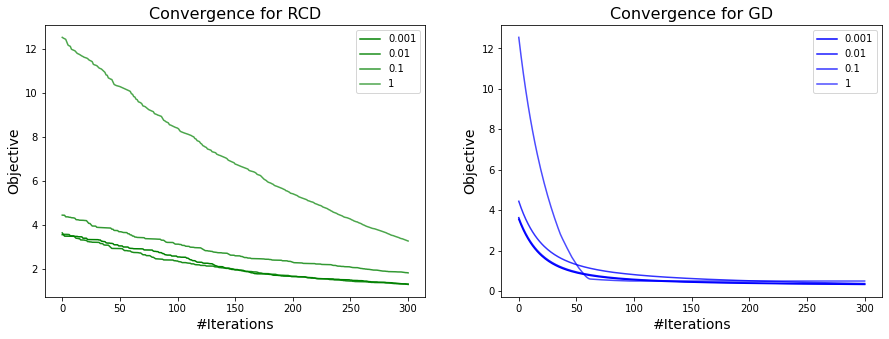

In [ ]:
################# Plot the results across all iterations
import matplotlib.pyplot as plt
# Evolution of the loss
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
for i in range(len(lbda)):
    plt.plot(obj[0,i,:], label=lbda[i], c='g', alpha=1-0.1*i)
    # plt.semilogy(i,lw=2)
plt.title("Convergence for RCD", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend();


plt.subplot(1,2,2)
for i in range(len(lbda)):
    plt.plot(obj[1,i,:], label=lbda[i], c='b', alpha=1-0.1*i)
    # plt.semilogy(i,lw=2)
plt.title("Convergence for GD", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend();

From the above plots we see that even for a number of different regularisation parameters, GD performs better than RCD. Note that GD is simply RCD, but with a single block. The objective value for GD converges quickly to 0 whereas RCD has much slower convergence. This makes sense since less information is incorporated at each step of the algorithm when only a single coordinate is updated.  

Consider also the final iterates of GD vs. those of RCD for different values of $\lambda$ and we note that GD consistenly performs better than RCD.

In [ ]:
lbda = [0.001,0.01, 0.05, 0.1, 0.5]
nits=300
th = np.zeros((2, len(lbda), 9))
obj = np.zeros((2, len(lbda), nits+1))
sp = np.zeros((2, len(lbda), nits+1))
step = 0.015

for i in range(len(lbda)):
    l = lbda[i]
    # print(l, end='\r')
    th[0,i,:], obj[0,i,:], sp[0,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=1, nits=nits, step=step)
    th[1,i,:], obj[1,i,:], sp[1,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=d, nits=nits, step=step)

errs = [obj[0], obj[1]]
sparsity = [sp[0], sp[1]]
titles = ['RC (nb=1)', 'GD(nb=d)']

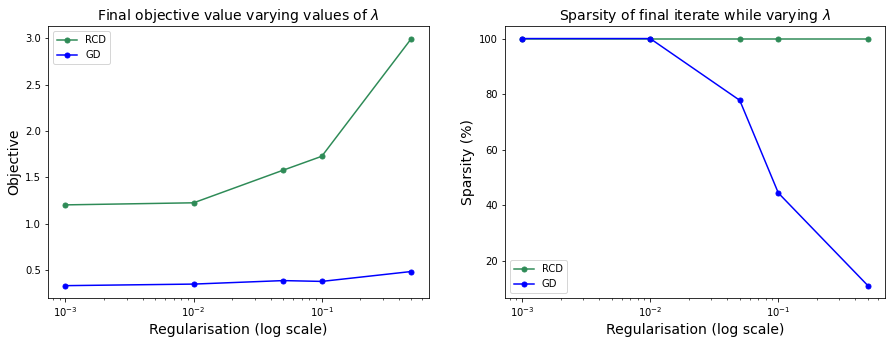

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.semilogx(lbda, obj[0][:, -1], '.-', c='seagreen', markersize=10)
plt.semilogx(lbda, obj[1][:, -1], '.-', c='b', markersize=10)
plt.legend(('RCD', 'GD'));
plt.title(r"Final objective value varying values of $\lambda$", fontsize=14)
plt.xlabel("Regularisation (log scale)", fontsize=14)
plt.ylabel("Objective", fontsize=14);

plt.subplot(1,2,2)
plt.semilogx(lbda, sp[0,:,-1]*100, '.-', markersize=10, c='seagreen', label='RCD')
plt.semilogx(lbda, sp[1,:,-1]*100, '.-', markersize=10, c='b', label='GD');
plt.title(r"Sparsity of final iterate while varying $\lambda$", fontsize=14)
plt.xlabel("Regularisation (log scale)", fontsize=14)
plt.ylabel("Sparsity (%)", fontsize=14)
plt.legend();

The regularisation parameter enforces sparsity, and has a greater effect on gradient descent by forcing it to converge faster.

## Question 2: Stochastic RCD
_Combine randomized block coordinate descent with stochastic gradient (i.e. the method from Part 3). Do you observe a benefit from using coordinates together with stochastic gradient?_

The coordinate descent method (RCD) may be written as 
$$ 
    \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \nabla_{j_k} f(\mathbf{x}_k) \mathbf{e}_{j_k},
$$
and stochastic gradient (SG) as 
$$
    \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \nabla f_{i_k}(\mathbf{x}_k),
$$

We combine the two methods SG and RCD to obtain Randomised Coordinate Stochastic Gradient Coordinate (RCSG) which may be expressed as
$$ 
    \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \nabla_{j_k} f_{i_K}(\mathbf{x}_k) \mathbf{e}_{j_k},
$$

where $j_k \in \{1,\dots,d\}$ and $i_k \in \{1,\dots,n\}$

In [ ]:
from optilibrary import stochRCD

In [ ]:
th = []
obj = []
sparsity = []

NumBlocks = [1, 8]
nb_epochs =50
nbset=int(n/10)

for nb in NumBlocks:
    x1,obj1,spars1 = stochRCD(A=X_train, y=y_train, lbda=0, nbatch=nbset, ncoords=nb, n_iter=int(nb_epochs*n/nbset))
    th.append(x1)
    obj.append(obj1)
    sparsity.append(spars1)
obj = np.array(obj).T
obj.shape

We now have 4 methods of interest to be compared, namely
- Gradient descent
- Randomised coordinate descent
- Stochastic Gradient
- Randomised Coordinate Stochastic Gradient

We run a single iteration of 30 epochs using the same stepsize $\tfrac{1}{L_{\max}}$ for every coordinate.

In [ ]:
nb_epochs = 30
nbset=int(n/2) #just to speed up runtime

#GD has batch size n and ncoords=d
print("GD")
xGD, objGD, sparsGD = stochRCD(X_train, y_train, nbatch=n, ncoords=d, n_iter=nb_epochs)
# RCD has batch size n and ncoords = 1
print("RCD")
xRCD, objRCD, sparsRCD = stochRCD(X_train, y_train, nbatch=n, ncoords=1, n_iter=nb_epochs)
#SGD has batch size 1 and nblocs=d
print("SG")
xSG, objSG, sparsSG = stochRCD(X_train, y_train, nbatch=nbset, ncoords=d, n_iter=int(nb_epochs*n/nbset))
#RCSG
print("RCSG")
xRCSG, objRCSG, sparsRCSG = stochRCD(X_train, y_train, nbatch=nbset, ncoords=1, n_iter=int(nb_epochs*n/nbset))

METHOD 	FINAL OBJECTIVE
GD: 	0.472224
RCD: 	0.472838
SG: 	0.472131
RCSG: 	0.472797


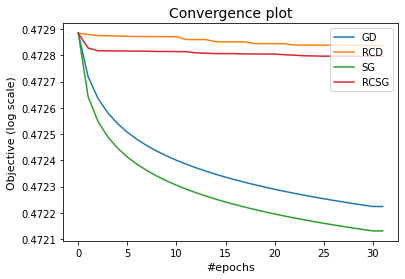

In [ ]:
OG = [objGD, objRCD, objSG, objRCSG]
# OG = np.array(OG).T #[np.array(i).T for i in OG])
Labels = ['GD', 'RCD', 'SG', 'RCSG']
print("METHOD \tFINAL OBJECTIVE")

for i in range(len(OG)):
    plt.plot(OG[i])
    print(f"{Labels[i]}: \t{np.round(OG[i][-1], 6)}")
plt.legend(Labels, loc='upper right');

# plt.plot(obj[:,-1])
plt.title("Convergence plot", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11);

The above figure shows that vanilla SG still outperforms all the other methods. 
Both variants of RCD perform worse than their full-coordinate counterparts, which makes sense in that at every epoch the same number of accesses to the gradient is performed, but less coordinates are used to calculate an update and thus the algorithm has less information at its disposal, resulting in steps which are less optimal.